# This is the original file where I get the wavemeans and params.
I should not use it again, I use the one to update variables instead

In [8]:
 %pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [9]:
from pylab import *
from scipy import *
from scipy import stats, io
import numpy as np
import struct
import tables as tb
from attrdict import AttrDict
import matplotlib.pyplot as plt
import os as os
from phy.io import KwikModel
import codecs as codecs
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick

In [10]:
#----------------------------------------------------------------------------------------
#SAVING BINARY OBJECTS DATA
#need to automate data folder creation
#----------------------------------------------------------------------------------------
import pickle 

def save_obj(obj, name ):
    with open('data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

# FUNCTIONS TO GET WAVE PARAMS

In [11]:
#----------------------------------------------------------------------------------------
# READKWIKINFO
#----------------------------------------------------------------------------------------
# We read the data of the output from klusterkwik: spike times and cluster-number of each
# cluster-number is in klustaviewa series (can be as high as 130 e.g.)
# Grupete stands for cluster groups! 2: good clusters, 1: multiunits, 0: unsorted, 3: noise
def readkwikinfo(kwik, grupete=3):
    model = KwikModel(kwik) # load kwik model from file
    spiketimes = model.spike_times # extract the absolute spike times
    clusters = model.cluster_groups # extract the cluster names
    sample_rate = model.sample_rate # extract sampling freq
    
    spikedata = {} # initialise dictionary
    for cluster in clusters.keys():
        clustergroup = clusters[cluster]
        if clustergroup==grupete: # only look at specified type of cluster, 0 = noise, 1 = MUA, 2 = GOOD, 3 = unsorted
            spiketimematrix = AttrDict({'spike_times': np.zeros(len(spiketimes[where(model.spike_clusters==cluster)]))})
            spiketimematrix.spike_times = spiketimes[where(model.spike_clusters==cluster)]
            spikedata[cluster] = spiketimematrix # data structure is a dictionary with attribute accessible spiketimes
            # attribute accessible means that spikedata.spike_times works, normal dictionaries would be spikedata[spike_times]
    
    model.close()
    return spikedata, sample_rate



#----------------------------------------------------------------------------------------
# READ KWIK WAVE INFO
def readkwikwaveinfo(wavedata,kwik,expe,meas, grupete=2,samples=48,electrodes=8):
    model = KwikModel(kwik) # load kwik model from file
    spiketimes = model.spike_times # extract the absolute spike times
    clusters = model.cluster_groups # extract the cluster names
    #sample_rate = model.sample_rate # extract sampling freq
    waveforms = model.waveforms
    
    if wavedata == False: wavedata = dict()
    
    for cluster in clusters.keys():
        clustergroup = clusters[cluster]
        if clustergroup==grupete: # only look at specified type of cluster, 0 = noise, 1 = MUA, 2 = GOOD, 3 = unsorted
            
            wavematrix = AttrDict({'waves': np.zeros(len(spiketimes[where(model.spike_clusters==cluster)]))})
            
            
            wavematrix.waves = waveforms[(model.spike_clusters==cluster)]
                        
            wavematrix.update(AttrDict({'meanwave' : np.zeros([samples,electrodes]), 'stdwave' : np.zeros([samples,electrodes])}))
            wavematrix.meanwave = mean(wavematrix.waves[:,:,:],axis=0)
            wavematrix.stdwave = std(wavematrix.waves[:,:,:],axis=0)
            
            parnames, params, electrode,bigwave = Getwaveparams(wavematrix.meanwave)
            
            wavematrix.update(AttrDict({'params' : params, 'electrodemax': electrode,'parnames': parnames, 'bigwave' : bigwave}))
            
            wavematrix.update(AttrDict({'clusnum': cluster,'exp' : int(expe) , 'meas': int(meas[1]) , 'shank': int(meas[3]), 'bigwavestd': wavematrix.stdwave[:,electrode]  }))
            codename = 'exp'+ str(expe) + '_' +meas + '_c' + str(cluster)
            
            #Comment to save all waveforms We don't save now for just only having the features
            wavematrix.waves = []
                        
            wavedata[codename] = wavematrix
            # attribute accessible means that spikedata.spike_times works, normal dictionaries would be spikedata[spike_times]
    
    
    model.close()
    return 

#----------------------------------------------------------------------------------------
#GET WAVE PARAMS
def Getwaveparams(Waves, zero_correct=False):
    
      #here I get the peak to peak maximum
    p2p = amax(Waves,0)-amin(Waves,0)
       
    #here I get the electrode number of biggest waveform
    electrode = where(p2p==max(p2p))[0][0]
    
    #I use the biggest waveform, already corrected for 0
    Wave = Waves[:,electrode]
    
    #I get the minimum
    minimo = min(Wave)
    
    plot(Wave)
    plot(arange(48),0*arange(48))
    
    #I find max and min 
    minim = where(Wave== minimo)[0][0]
    table_max = where(numpy.r_[False, Wave[1:] > Wave[:-1]] & numpy.r_[Wave[:-1] > Wave[1:], False])[0]

    #have to get local max before minimum and after minimum
    tablebefore = table_max[where(table_max<minim)]
    tableafter = table_max[where(table_max>minim)]
    
    #--------------------------------------------------------------------    
    if len(tablebefore)<1:
        peak1 = 0   #if there is no second peak, i select the las point
    else:
        #peak2 = table_max[1] 
        peak1 =  table_max[Wave[table_max] == max(Wave[tablebefore])][0]
    peak1val = Wave[peak1]/minimo
    #--------------------------------------------------------------------
    if len(tableafter)<1:
        peak2 = 47   #if there is no second peak, i select the las point
    else:
        #peak2 = table_max[1] 
        peak2 =  table_max[Wave[table_max] == max(Wave[tableafter])][0]
    peak2val = Wave[peak2]/minimo
    #--------------------------------------------------------------------
    
    #relative to minimum
    prel1 = peak1 - minim
    prel2 = peak2 -minim
            
    #I find previous index of 0 crossings
    table_0d = where(numpy.r_[Wave[1:] <= 0,False] & numpy.r_[Wave[:-1]>0,False])[0]
    table_0u = where(numpy.r_[Wave[1:] >= 0,False] & numpy.r_[Wave[:-1]<0,False])[0]
    
    c1 = table_0d[0]
    c2 = table_0u[0]

    if c2<minim:#if there is an extra crossing
        #c1 = table_0d[1]
        c2 = table_0u[1]
    #--------------------------------------------------------------------    
    if len(table_0d)<2:
        c3 = 47   #if there is no second cross
    else:
        c3 =  table_0d[len(table_0d)-1] 
      
    #get 0 crossings
    cr1 = c1+abs(Wave[c1])/(abs(Wave[c1])+abs(Wave[c1+1]))
    cr2 = c2+abs(Wave[c2])/(abs(Wave[c2])+abs(Wave[c2+1]))
    
    widthtot = c3-cr1
    
    if c3==47 and Wave[c3-2]>Wave[c3]: 
        cr3 = c3 + Wave[c3]*2/(Wave[c3-2]-Wave[c3])
    else:
        cr3 = c3
        
    if cr3> 65: cr3=65
    
    #relative to minimum
    crel1 = cr1-minim
    crel2 = cr2-minim
    crel3 = cr3-minim
    
    #Get the widths
    width0 = cr2-cr1
    widthtotint = cr3-cr1
    
    amp50 = minimo/2
    amp25 = minimo/4
    
    #get the amplitude crossings
    table_0d = where(numpy.r_[Wave[1:] <= amp50,False] & numpy.r_[Wave[:-1]>amp50,False])[0]
    table_0u = where(numpy.r_[Wave[1:] >= amp50,False] & numpy.r_[Wave[:-1]<amp50,False])[0]
        
    c1 = table_0d[0]
    c2 = table_0u[0]
    
    cross1 = c1+abs(amp50-Wave[c1])/(abs(Wave[c1]-Wave[c1+1]))
    cross2 = c2+abs(amp50-Wave[c2])/(abs(Wave[c2]-Wave[c2+1]))
        
    width50 = cross2-cross1
    #---------------------------------
    
    table_0d = where(numpy.r_[Wave[1:] <= amp25,False] & numpy.r_[Wave[:-1]>amp25,False])[0]
    table_0u = where(numpy.r_[Wave[1:] >= amp25,False] & numpy.r_[Wave[:-1]<amp25,False])[0]
    
    c1 = table_0d[0]
    c2 = table_0u[0]
    
    cross1 = c1+abs(amp25-Wave[c1])/(abs(Wave[c1]-Wave[c1+1]))
    cross2 = c2+abs(amp25-Wave[c2])/(abs(Wave[c2]-Wave[c2+1]))
        
    width25 = cross2-cross1
    
    pnames =['widths0-25-50-tot-tot_int','cross1-2-3','crossrel1-2-3','peakVals', 'peaks1-2','peaksrel1-2','mins']

    
    return pnames,[[width0, width25, width50, widthtot,widthtotint],[cr1, cr2,cr3],[crel1,crel2,crel3],[peak1val,peak2val], [peak1, peak2],[prel1,prel2],  [minim, minimo]], electrode,Wave

#----------------------------------------------------------------------------------------
#Wave DATABASE
#def Wavedatabase(expe,meas,cluster,electrode,params):



# Experiment Files and Folders

In [13]:
# In this cell you put all the information to make the code portable from computer to computer
# You have to place all the file names and experiments, then you loop whichever you want to analyse
#--------------------------------------------------------------------------------
#Experiment numbers
ExpeNum = [20,22,23,24,25,26,27,28,29,30,31,32]

#--------------------------------------------------------------------------------
#Folders for measurements and experiments (this is how we separate shanks in folders for individual analyses)
m164 = ['m1s1','m1s2','m1s3','m1s4','m1s5','m1s6','m1s7','m1s8']
m264 = ['m2s1','m2s2','m2s3','m2s4','m2s5','m2s6','m2s7','m2s8']
m364 = ['m3s1','m3s2','m3s3','m3s4','m3s5','m3s6','m3s7','m3s8']
m464 = ['m4s1','m4s2','m4s3','m4s4','m4s5','m4s6','m4s7','m4s8']

#--------------------------------------------------------------------------------
#Kwik files    

files20 = [ 'MEAS-150707-1_ele01_ele08.kwik',
            'MEAS-150707-1_ele09_ele16.kwik',
            'MEAS-150707-1_ele17_ele24.kwik',
            'MEAS-150707-1_ele25_ele32.kwik',
            'MEAS-150707-23_ele01_ele08.kwik',
            'MEAS-150707-23_ele16_ele09.kwik']#,
            #'MEAS-150707-23_ele17_ele24.kwik',  not in S2
            #'MEAS-150707-23_ele25_ele32.kwik',] not in S2

files22 = [ 'MEAS-150716-12_ele01_ele08.kwik',
            'MEAS-150716-12_ele09_ele16.kwik',
            'MEAS-150716-12_ele17_ele24.kwik',
            'MEAS-150716-12_ele25_ele32.kwik',
            'MEAS-150716-3_ele01_ele08.kwik',
            'MEAS-150716-3_ele09_ele16.kwik',
            'MEAS-150716-3_ele17_ele24.kwik',
            'MEAS-150716-3_ele25_ele32.kwik',]

files23 = [ 'MEAS-151027-1_ele01_ele08.kwik',
            'MEAS-151027-1_ele09_ele16.kwik',
            #'MEAS-151027-1_ele17_ele24.kwik', out of S2
            #'MEAS-151027-1_ele25_ele32.kwik', out of S2
            #'MEAS-151027-1_ele33_ele40.kwik', out of S2
            #'MEAS-151027-1_ele41_ele48.kwik', out of S2
            #'MEAS-151027-1_ele49_ele56.kwik', out of S2
            #'MEAS-151027-1_ele57_ele64.kwik', out of S2
            'MEAS-151027-2_ele01_ele08.kwik',
            'MEAS-151027-2_ele09_ele16.kwik',
            'MEAS-151027-2_ele17_ele24.kwik',
            'MEAS-151027-2_ele25_ele32.kwik',
            'MEAS-151027-2_ele33_ele40.kwik']#,
            #'MEAS-151027-2_ele41_ele48.kwik',  out of S2
            #'MEAS-151027-2_ele49_ele56.kwik',  out of S2
            #'MEAS-151027-2_ele57_ele64.kwik']  out of S2

files24 = [#'MEAS-151103-1_EXTRACTED_ele25_ele32.kwik',  no functional responses
           'MEAS-151103-1_EXTRACTED_ele33_ele40.kwik',  
           'MEAS-151103-1_EXTRACTED_ele41_ele48.kwik',  
           'MEAS-151103-1_EXTRACTED_ele49_ele56.kwik',  
           'MEAS-151103-1_EXTRACTED_ele57_ele64.kwik',
           #'MEAS-151103-2_ele33_ele40.kwik',   no units
           'MEAS-151103-2_ele41_ele48.kwik',
           'MEAS-151103-2_ele49_ele56.kwik',
           'MEAS-151103-2_ele57_ele64.kwik']

#OUT OF S2
files25 = [ 'MEAS-151105-1good_ele01_ele08.kwik',
            'MEAS-151105-1good_ele09_ele16.kwik',
            'MEAS-151105-1good_ele17_ele24.kwik',
            'MEAS-151105-1good_ele25_ele32.kwik',
            'MEAS-151105-1good_ele33_ele40.kwik',
            'MEAS-151105-1good_ele41_ele48.kwik',
            'MEAS-151105-1good_ele49_ele56.kwik',
            'MEAS-151105-1good_ele57_ele64.kwik',
            'MEAS-151105-2_ele01_ele08.kwik',
            'MEAS-151105-2_ele09_ele16.kwik',
            'MEAS-151105-2_ele17_ele24.kwik',
            'MEAS-151105-2_ele25_ele32.kwik',
            'MEAS-151105-2_ele33_ele40.kwik',
            'MEAS-151105-2_ele41_ele48.kwik',
            'MEAS-151105-2_ele49_ele56.kwik',
            'MEAS-151105-2_ele57_ele64.kwik']

files26 = [ 'MEAS-151110-1_ele01_ele08.kwik',
            'MEAS-151110-1_ele09_ele16.kwik',
            'MEAS-151110-1_ele17_ele24.kwik',
            'MEAS-151110-1_ele25_ele32.kwik',
            'MEAS-151110-1_ele33_ele40.kwik',
            'MEAS-151110-1_ele41_ele48.kwik',
            'MEAS-151110-1_ele49_ele56.kwik',
            #'MEAS-151110-1_ele57_ele64.kwik', out of S2
            'MEAS-151110-2_ele01_ele08.kwik',
            'MEAS-151110-2_ele09_ele16.kwik',
            'MEAS-151110-2_ele17_ele24.kwik',
            'MEAS-151110-2_ele25_ele32.kwik']#,
            #'MEAS-151110-2_ele33_ele40.kwik',  no units
            #'MEAS-151110-2_ele41_ele48.kwik', out of S2
            #'MEAS-151110-2_ele49_ele56.kwik', no units
            #'MEAS-151110-2_ele57_ele64.kwik', no units
            #'MEAS-151110-3_ele01_ele08.kwik',  out of S2
            #'MEAS-151110-3_ele09_ele16.kwik',  out of S2
            #'MEAS-151110-3_ele17_ele24.kwik',  out of S2
            #'MEAS-151110-3_ele25_ele32.kwik',  out of S2
            #'MEAS-151110-3_ele33_ele40.kwik',  out of S2
            #'MEAS-151110-3_ele41_ele48.kwik',  out of S2
            #'MEAS-151110-3_ele49_ele56.kwik',  no units
            #'MEAS-151110-3_ele57_ele64.kwik']  no units

files27  = ['MEAS-151112-1_ele01_ele08.kwik',
            'MEAS-151112-1_ele09_ele16.kwik',
            'MEAS-151112-1_ele17_ele24.kwik',
            'MEAS-151112-1_ele25_ele32.kwik',
            'MEAS-151112-1_ele33_ele40.kwik',
            'MEAS-151112-1_ele41_ele48.kwik',
            'MEAS-151112-1_ele49_ele56.kwik',
            'MEAS-151112-1_ele57_ele64.kwik',
            'MEAS-151112-2_ele01_ele08.kwik',
            'MEAS-151112-2_ele09_ele16.kwik',
            'MEAS-151112-2_ele17_ele24.kwik',
            'MEAS-151112-2_ele25_ele32.kwik',
            'MEAS-151112-2_ele33_ele40.kwik',
            'MEAS-151112-2_ele41_ele48.kwik',
            'MEAS-151112-2_ele49_ele56.kwik',
            'MEAS-151112-2_ele57_ele64.kwik',
            'MEAS-151112-3_ele01_ele08.kwik',
            'MEAS-151112-3_ele09_ele16.kwik',
            'MEAS-151112-3_ele17_ele24.kwik',
            'MEAS-151112-3_ele25_ele32.kwik',
            'MEAS-151112-3_ele33_ele40.kwik',
            'MEAS-151112-3_ele41_ele48.kwik',
            'MEAS-151112-3_ele49_ele56.kwik',
            'MEAS-151112-3_ele57_ele64.kwik']

files28 =  ['MEAS-151116-1_ele01_ele08.kwik',
            'MEAS-151116-1_ele09_ele16.kwik',
            'MEAS-151116-1_ele17_ele24.kwik',
            'MEAS-151116-1_ele25_ele32.kwik',
            'MEAS-151116-1_ele33_ele40.kwik',
            'MEAS-151116-1_ele41_ele48.kwik',
            'MEAS-151116-1_ele49_ele56.kwik',
            #'MEAS-151116-1_ele57_ele64.kwik',
            'MEAS-151116-2_ele01_ele08.kwik',
            'MEAS-151116-2_ele09_ele16.kwik',
            'MEAS-151116-2_ele17_ele24.kwik',
            'MEAS-151116-2_ele25_ele32.kwik',
            'MEAS-151116-2_ele33_ele40.kwik',
            'MEAS-151116-2_ele41_ele48.kwik',
            'MEAS-151116-2_ele49_ele56.kwik',
            'MEAS-151116-2_ele57_ele64.kwik',
            'MEAS-151116-3_ele01_ele08.kwik',
            'MEAS-151116-3_ele09_ele16.kwik',
            'MEAS-151116-3_ele17_ele24.kwik',
            'MEAS-151116-3_ele25_ele32.kwik',
            'MEAS-151116-3_ele33_ele40.kwik',
            'MEAS-151116-3_ele41_ele48.kwik',
            'MEAS-151116-3_ele49_ele56.kwik',
            'MEAS-151116-3_ele57_ele64.kwik']

files29  = ['MEAS-151118-1_ele01_ele08.kwik',
            'MEAS-151118-1_ele09_ele16.kwik',
            'MEAS-151118-1_ele17_ele24.kwik',
            'MEAS-151118-1_ele25_ele32.kwik',
            'MEAS-151118-1_ele33_ele40.kwik',
            'MEAS-151118-1_ele41_ele48.kwik',
            'MEAS-151118-1_ele49_ele56.kwik',
            'MEAS-151118-1_ele57_ele64.kwik',
            'MEAS-151118-2_ele01_ele08.kwik',
            'MEAS-151118-2_ele09_ele16.kwik',
            'MEAS-151118-2_ele17_ele24.kwik',
            'MEAS-151118-2_ele25_ele32.kwik',
            'MEAS-151118-2_ele33_ele40.kwik',
            'MEAS-151118-2_ele41_ele48.kwik',
            'MEAS-151118-2_ele49_ele56.kwik',
            'MEAS-151118-2_ele57_ele64.kwik',
            'MEAS-151118-3_ele01_ele08.kwik',
            'MEAS-151118-3_ele09_ele16.kwik',
            'MEAS-151118-3_ele17_ele24.kwik',
            'MEAS-151118-3_ele25_ele32.kwik',
            'MEAS-151118-3_ele33_ele40.kwik',
            'MEAS-151118-3_ele41_ele48.kwik',
            'MEAS-151118-3_ele49_ele56.kwik',
            'MEAS-151118-3_ele57_ele64.kwik']


files30  = ['MEAS-151208-2_ele01_ele08.kwik',
            'MEAS-151208-2_ele09_ele16.kwik',
            'MEAS-151208-2_ele17_ele24.kwik',
            'MEAS-151208-2_ele25_ele32.kwik',
            'MEAS-151208-2_ele33_ele40.kwik',
            'MEAS-151208-2_ele41_ele48.kwik',
            'MEAS-151208-2_ele49_ele56.kwik',
            'MEAS-151208-2_ele57_ele64.kwik',
            'MEAS-151208-3_ele01_ele08.kwik',
            'MEAS-151208-3_ele09_ele16.kwik',
            'MEAS-151208-3_ele17_ele24.kwik',
            'MEAS-151208-3_ele25_ele32.kwik',
            'MEAS-151208-3_ele33_ele40.kwik',
            'MEAS-151208-3_ele41_ele48.kwik',
            'MEAS-151208-3_ele49_ele56.kwik',
            'MEAS-151208-3_ele57_ele64.kwik',
            'MEAS-151208-4_ele01_ele08.kwik',
            'MEAS-151208-4_ele09_ele16.kwik',
            'MEAS-151208-4_ele17_ele24.kwik',
            'MEAS-151208-4_ele25_ele32.kwik',
            'MEAS-151208-4_ele33_ele40.kwik',
            'MEAS-151208-4_ele41_ele48.kwik',
            'MEAS-151208-4_ele49_ele56.kwik',
            'MEAS-151208-4_ele57_ele64.kwik',
            'MEAS-151208-5_ele01_ele08.kwik',
            'MEAS-151208-5_ele09_ele16.kwik',
            'MEAS-151208-5_ele17_ele24.kwik',
            'MEAS-151208-5_ele25_ele32.kwik',
            'MEAS-151208-5_ele33_ele40.kwik',
            'MEAS-151208-5_ele41_ele48.kwik',
            'MEAS-151208-5_ele49_ele56.kwik',
            'MEAS-151208-5_ele57_ele64.kwik']


files31 = [ #'MEAS-151210-1_ele01_ele08.kwik',  no units
            #'MEAS-151210-1_ele09_ele16.kwik',  no units
            #'MEAS-151210-1_ele17_ele24.kwik',  no units
            #'MEAS-151210-1_ele25_ele32.kwik',  no units
            #'MEAS-151210-1_ele33_ele40.kwik',  no units
            'MEAS-151210-1_ele41_ele48.kwik',
            'MEAS-151210-1_ele49_ele56.kwik',
            'MEAS-151210-1_ele57_ele64.kwik',
            #'MEAS-151210-2_ele01_ele08.kwik',   out of S2
            #'MEAS-151210-2_ele09_ele16.kwik',   out of S2
            #'MEAS-151210-2_ele17_ele24.kwik',   out of S2
            #'MEAS-151210-2_ele25_ele32.kwik',   out of S2
            'MEAS-151210-2_ele33_ele40.kwik',
            'MEAS-151210-2_ele41_ele48.kwik',
            'MEAS-151210-2_ele49_ele56.kwik',
            'MEAS-151210-2_ele57_ele64.kwik',
            #'MEAS-151210-3_ele01_ele08.kwik',   out of S2
            #'MEAS-151210-3_ele09_ele16.kwik',   no units
            #'MEAS-151210-3_ele17_ele24.kwik',   no units
            #'MEAS-151210-3_ele25_ele32.kwik',   out of S2
            'MEAS-151210-3_ele33_ele40.kwik',
            'MEAS-151210-3_ele41_ele48.kwik',
            'MEAS-151210-3_ele49_ele56.kwik',
            'MEAS-151210-3_ele57_ele64.kwik']

files32 = [ 'MEAS-151214-1_ele01_ele08.kwik',
            'MEAS-151214-1_ele09_ele16.kwik',
            'MEAS-151214-1_ele17_ele24.kwik',
            'MEAS-151214-1_ele25_ele32.kwik',
            'MEAS-151214-1_ele33_ele40.kwik',
            'MEAS-151214-2_ele01_ele08.kwik',
            'MEAS-151214-2_ele09_ele16.kwik',
            'MEAS-151214-2_ele17_ele24.kwik',
            'MEAS-151214-2_ele25_ele32.kwik',
            'MEAS-151214-2_ele33_ele40.kwik']

#--------------------------------------------------------------------------------
#--------------------------------------------------------------------------------
# Here I create my dictionary of experiments
Expe={}
Vtags={}
Stim={}
for num in ExpeNum: 
    Expe[num] = dict()
    Vtags[num] = dict()
#---------------------------------------
i=0        
for meas in np.append(m164[0:4],m364[0:2]):
    Expe[20][meas] = files20[i]
    i+=1
#---------------------------------------
i=0 
for meas in np.append(m164[0:4],m364[0:4]):
    Expe[22][meas] = files22[i]
    i+=1
#---------------------------------------
i=0 
for meas in np.append(m164[0:2],m264[0:5]):
    Expe[23][meas] = files23[i]
    i+=1
#---------------------------------------
i=0
for meas in np.append(m164[4:8],m264[5:8]):    
    Expe[24][meas] = files24[i]
    i+=1
#---------------------------------------
i=0 
for meas in np.append(m164,m264):    
    Expe[25][meas] = files25[i]
    i+=1
#---------------------------------------
i=0
for meas in np.append(m164[0:7],m264[0:4]):
    Expe[26][meas] = files26[i]
    i+=1
#---------------------------------------
i=0
for meas in np.append(np.append(m164[0:7],m264),m364):    
    Expe[28][meas] = files28[i]
    i+=1
#---------------------------------------    
i=0
for meas in np.append(np.append(m164,m264),m364):    
    Expe[27][meas] = files27[i]
    Expe[29][meas] = files29[i]
    Expe[30][meas] = files30[i]
    i+=1
#---------------------------------------    
for meas in m464:
    Expe[30][meas] = files30[i]
    i+=1
i=0
#---------------------------------------    
i=0
for meas in np.append(np.append(m164[5:8],m264[4:8]),m364[4:8]):    
    Expe[31][meas] = files31[i]
    i+=1
i=0
#---------------------------------------    
for meas in np.append(m164[0:5],m264[0:5]):
    Expe[32][meas] = files32[i]
    i+=1

#--------------------------------------------------------------------------------
#Vtag files 
Vtags[20] = ['MEAS-150707-1_Vtag1.dat','nada','MEAS-150707-23_Vtag1.dat']
Vtags[22] = ['MEAS-150716-12_Vtag1.dat','nada','MEAS-150716-3_Vtag1.dat']
Vtags[23] = ['MEAS-151027-1_Vtag1.dat','MEAS-151027-2_Vtag1.dat']
Vtags[23] = ['MEAS-151027-1_Vtag1.dat','MEAS-151027-2_Vtag1.dat']
Vtags[24] = ['MEAS-151103-1_Vtag1.dat','MEAS-151103-2_Vtag1.dat']
Vtags[25] = ['MEAS-151105-1good_Vtag1.dat','MEAS-151105-2_Vtag1.dat']
Vtags[26] = ['MEAS-151110-1_Vtag1.dat','MEAS-151110-2_Vtag1.dat','MEAS-151110-3_Vtag1.dat']
Vtags[27] = ['MEAS-151112-1_Vtag1.dat','MEAS-151112-2_Vtag1.dat','MEAS-151112-3_Vtag1.dat']
Vtags[28] = ['MEAS-151116-1_Vtag1.dat','MEAS-151116-2_Vtag1.dat','MEAS-151116-3_Vtag1.dat']
Vtags[29] = ['MEAS-151118-1_Vtag1.dat','MEAS-151118-2_Vtag1.dat','MEAS-151118-3_Vtag1.dat']
Vtags[30] = ['MEAS-151208-2_Vtag1.dat','MEAS-151208-3_Vtag1.dat','MEAS-151208-4_Vtag1.dat','MEAS-151208-5_Vtag1.dat']
Vtags[31] = ['MEAS-151210-1_Vtag1.dat','MEAS-151210-2_Vtag1.dat','MEAS-151210-3_Vtag1.dat']
Vtags[32] = ['MEAS-151214-1_Vtag1.dat','MEAS-151214-2_Vtag1.dat']

#--------------------------------------------------------------------------------
#Stimulus type
for i in range(23,33):
    Stim[i] = 'big_STIM_FC_corrected'
for i in range(15,23):
    Stim[i] = 'big_STIM'
for i in range(10,15):
    Stim[i] = 'small_STIM'  
    
#--------------------------------------------------------------------------------
#Root folder to work in, such all will be in subfolders 
#e.g.: "/EXP_23/m1s1/" for data or "/STIM/" for stims
rootF = '/home/matias/WORKSPACE/'    
stimFolder = rootF +'STIM/'

#I have a separate folder for exp 22 and before
rootF_kwiks = rootF    #uncomment this to work with the other root folder
#rootF_kwiks = '/media/matias/DATA/WORKSPACE2/'

#--------------------------------------------------------------------------------
#Initialize wave features dictionary
Wavedata = dict()

# Define and load data files from experiments

24
group: 2
m1s5
   building waves
m1s6
   building waves
m1s7
   building waves
m1s8
   building waves
m2s6
   building waves
m2s7
   building waves
m2s8
   building waves


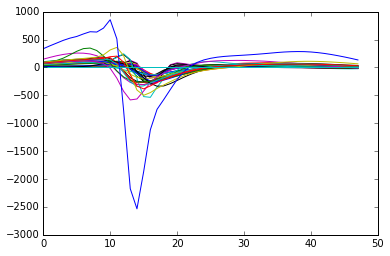

In [14]:
global binname, textname
#---------------------------------------------------------------------------------------
SelExp = [24] #[22,24,26,27,28,29,30,31,32]   #Expe                                        #select experiment numbers!
grupete = [2]   #select cluster groups! 2 for good clusters 1 for multiunits, 3 for unsorted

#select measurement and/or shanks!
Measurements = m364[0:2]           #['m1s1']#['m3s1','m3s3']#m12[-4:]#['m1s1','m1s2','m1s3','m1s4']   

# choice code not to ploteverything at the same time
ploteo = [0,0,0,0]                                           #1 to make plots: psth,sta,ufc,stc

dirs =[]

#--------------------------------------------------------------------------------
# Loop Experiments
#--------------------------------------------------------------------------------
last_exp=0     #we use this to load stim only when we change experiment
for expe in SelExp:
    
    #uncomment if we want a whole file for all the experiments
    Wavedata = dict()
    
    Measurements = sorted(Expe[expe])                         #uncommento to select all
    print(expe)

    #--------------------------------------------------------------------------------
    #loop goodunits
    for group in grupete:   #2 for good clusters 1 for multiunits 3 for unsorted
        #folder names
        if group ==2:
            dirs  = [rootF + 'OUTPUT/PDFwaves/EXP_'+str(expe)]
        print('group:', group)
        #--------------------------------------------------------------------------------
        #loop measurements and shanks
        measurements = Expe[expe]                            
                 
        for meas in Measurements:           
            print(meas)
            #---------------------------------------------------------------
            #select datafile
            sp_file = rootF_kwiks + 'EXP_' + str(expe) +'/Spike_Sorting/'+ meas +'/'+ measurements[meas]
            
            #load datafile
            print('   building waves')
            readkwikwaveinfo(Wavedata,sp_file,str(expe),meas,group)  
            
            #---------------------------------------------------------------
            #load stimulus if looping new experiment, without trimming
           
            if len(Wavedata.keys())>0:                              #do only if there are clusters
                #--------------------------------------------------------------------------------
                #create output folders
                for dir in dirs:
                    if not os.path.exists(dir):
                        os.makedirs(dir) 
                dire = dirs[0] +'/'
                titles = 'Exp'+ str(expe) + '_Meas_' + meas[1] + '_Shank_' + meas[3]
                #--------------------------------------------------------------------------------
                #Wave params
                
                #print('   building waves')
                                        
                
                #--------------------------------------------------------------------------------
                #Plot Waves
                #print('   plotting')
                if ploteo[0]==1: display_all_PSTHs_of_recording(expe,hist_output, PSTH_spikes_counts, dire, t_before, t_after,group,STC_on,PW,titles)
         
    filesave ='wavedata' + str(expe)
    save_obj(Wavedata,filesave)

exp20_m1s1_c29


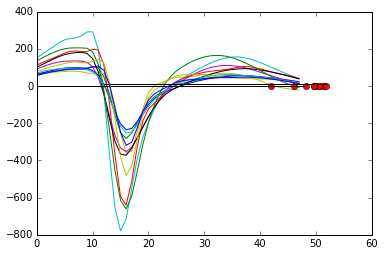

In [42]:
idx = list(Wavedata.keys())

print(idx[0])

listn = 0



n =idx[listn]

for n in idx:

#    print(Wavedata[n].parnames)

    Wavedata[n].params


    bigwave = Wavedata[n].bigwave
    par = Wavedata[n].params

    plot([0,48],[0,0])
    plot(bigwave)

    cross = par[1]
    width = par[0]

    plot(cross[2],0,'ro')

    plot([cross[0],cross[0]+width[4]],[10,10],'k')

In [ ]:
    filesave ='wavedata' + str(expe)
    save_obj(Wavedata,filesave)
    
    >>> x = {'a':1, 'b': 2}
>>> y = {'b':10, 'c': 11}
>>> z = x.update(y)
>>> print z
None
>>> x
{'a': 1, 'b': 10, 'c': 11}

In [15]:
idx = list(sorted(Wavedata.keys()))
idx[0]

print('keys: ',Wavedata[idx[0]].keys())

print('parnames: ',Wavedata[idx[0]].params_names)

print('firstidx: ' ,idx[0])

print('number of idx: ',len(idx))

print('params: ',Wavedata[idx[0]].params)

print(Wavedata.keys())

neuron=0

electrode = Wavedata[idx[neuron]].electrodemax

plot(Wavedata[idx[neuron]].bigwave)
plot(Wavedata[idx[neuron]].bigwave+Wavedata[idx[neuron]].bigwavestd)
plot(Wavedata[idx[neuron]].bigwave-Wavedata[idx[neuron]].bigwavestd)

wave0 = Wavedata[idx[0]]

wave0.bigwave

#print(wave0.waves.shape)

wave0.params

print(idx)

keys:  dict_keys(['meas', 'electrodemax', 'parnames', 'params', 'exp', 'bigwavestd', 'meanwave', 'stdwave', 'shank', 'waves', 'bigwave'])


AttributeError: 'AttrDict' instance has no attribute 'params_names'

In [ ]:
save_obj(Wavedata,'wavedata220')

neuron='12'



In [ ]:
Wavedata = load_obj('wavedata20')




In [ ]:
idx = sort(list(Wavedata.keys()))

print(Wavedata[idx[0]].keys())

Wavedata[idx[0]].params_names

Wavedata.keys()

In [ ]:
#Plotting waveforms

idx = sort(list(Wavedata.keys()))

neuron = idx[3]

print(neuron)

fig = figure(figsize=(3,20))

elec = [0,7,1,6,2,5,3,4]

print(size(Wavedata[neuron].meanwave[:,0]))

pos = [1,4,5,8,9,12,13,16]

pos2 = arange(1,9)

pos2linear = [2,1,3,0,4,7,5,6]



buzsaki=True

if buzsaki:
    pos = pos2
else:
    pos = pos2linear+1

i=0
origin=0
for i in arange(8):
    
    ax1 = fig.add_subplot(8,2,pos2[i])
    
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    #ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
   
    ax1.set_xlim([0, 48])
    ax1.set_ylim([-1000, 1000])
    
    #for x in arange(Spikes[neuron]['spike_times'].shape[0]):
    #    ax1.plot(arange(48),wave[neuron]['waves'][x,:,elec[i]],color='b')

    m =Wavedata[neuron].meanwave[:,elec[i]]
    s =Wavedata[neuron].stdwave[:,elec[i]]
    
    m=m-m[0]
    
    #sem= stats.sem (Waves[neuron]['waves'][:,:,elec[i]],axis=0)
    if buzsaki:
        if i%2==1:
            m=m-500
            origin =-500
        else: 
            m=m+500
            origin =500
    
    ax1.plot(arange(48),m,color='r')
    
    ax1.plot(arange(48),origin+0*arange(48))
    ax1.plot(arange(48),m+s,color='g')
    ax1.plot(arange(48),m-s,color='g')     
    
    ax1.set_xticks([])
    ax1.set_yticklabels([])
      
#print(Waves[21656]['waves'][100,:,0])
#print(Waves[21656]['waves'].shape)
#Spikes[21656]['spike_times'].shape